In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Cost Functions
In many cases, people use cost function and loss function interchangeably. If we have to make a distinction, a loss function is usually used to measure on a single sample, i.e. the distance between the predicted value and the true value, whereas a cost function is the sum of loss functions over the entire training set plus some penalty terms (regularization). A cost function can be used as objective function when the objective is to minimize the cost function. 

Cost functions are used to measure how good a model is. In machine learning and deep learning, gradient descent is commonly used in finding the minimum point of cost functions.

Selecting the right cost function is a key part in building machine learning/deep learning models.

This notebook introduces the following cost functions:
- [Cost Functions for Regression](#regression-costs)
    - [Mean Square Error (or L2)](#mse)
    - [Mean Absolute Error (or L1)](#mae)
    - [Huber Loss](#huber)
    - [Log Cosh Loss](#logcosh)
    - [Quantile Loss](#quantile)
- [Cost Functions for Classification](#classification-costs)
    - [Log Loss](#logloss)
    - [Hinge Loss](#hinge)
    - [KL Divergence](#kl)
    
Keras and TensorFlow provide many more loss functions implementations. You can check them out here:
- Keras: [[description](https://keras.io/losses/)][[code](https://github.com/keras-team/keras/blob/master/keras/losses.py)]
- TensorFlow: [[description](https://www.tensorflow.org/api_docs/python/tf/losses)][[code](https://github.com/tensorflow/tensorflow/blob/r1.12/tensorflow/python/ops/losses/losses_impl.py)]

## <a name='regression-costs'></a>Cost Functions for Regression

A regression model tries to build a mapping function from input variables X to a __continuous__ output variable y. The continuous output variable is a real-value (e.g. integer, or float). There is a type of problem called `logistic regression`. Although it has `regression` in this name, but in this notebook, it belongs to the classification family and uses [cost functions for classification](#classification-costs)

In [3]:
# use numpy to generate some random numbers

# for regression problems
# y_true is a list of integers from 1 to 100
y_true = np.arange(1, 101, 1)
# generate y_predict
noise = np.random.randn(100, ) + 5
y_pred = y_true + noise

# plot
plt.scatter(y_true, y_pred)
plt.xlabel('y_true')
plt.ylabel('y_pred')
plt.show()

### <a name='mse'></a> Mean Squared Error (MSE)
Square Error, a.k.a. $l2$ loss, quadratic loss

The definition of MSE is as below:
$$
MSE(y, \hat{y}) = \frac{1}{n} \times \sum_{i=1}^{n}{(y_i - \hat{y_i})^2}
$$ 

For each sample, calculate the squared difference between the predicted value ($y_i$) and the true value ($\hat{y_i}$), and then take the average of all samples.

When to use MSE:
- If detecting anomaly is important, then use MSE

When better NOT to use MSE:
- Outliers are just corrupted data
- It has multiple 'valleys'

In [15]:
def mean_squared_error(y_true, y_pred):
    return np.mean(np.square(y_pred - y_true))

In [16]:
mean_squared_error(y_true, y_pred)

26.757603738472284

### <a name='mae'></a> Mean Absolute Error (MAE)
Absolute Error, a.k.a. Laplace error, $l1$ loss 

It measures the average magnitude of errors in a set of predictions without considering their directions:
$$
MAE(y, \hat{y}) = \frac{1}{n} \times \sum_{i=1}^{n}{|y_i - \hat{y_i}|}
$$ 

For each sample, calculate the absolute difference between the predicted value ($y_i$) and the true value ($\hat{y_i}$), and then take the average of all samples. 

Compared to MSE, MAE is is not differentiable at origin. However, it is more robust to outliers (because errors are not squared). 

The problem with using MAE is that its gradient is a constant, and won't get smaller when approaching the optimal point, making it inefficient to find the solution. To fix this, dynamic learning rate can be used to decrease the step when approaching the minima. 

When to use MAE:
- Have a lot of outliers that are just corrupted data

In [13]:
def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

In [14]:
mean_absolute_error(y_true, y_pred)

5.055550685802622

### <a name='huber'></a>Huber Loss
Smooth Mean Absolute Error

Huber loss is a combination of MSE and MAE. It is quadratic when the residual is around origin, and linear when the residual is far from origin:
$$
huberloss(y_i, \hat{y_i}) = 
\begin{cases}
\frac{1}{2} (y_i - \hat{y_i})^2, & \text{for $|y_i - \hat{y_i}|\leqslant \delta$} \\
\delta |y_i - \hat{y_i}| - \frac{1}{2}\delta^2, & \text otherwise
\end{cases}
$$

The choice of $\delta$ is critical as it determines how tolerant you are to an outlier. Residuals larger than $\delta$ are minimized with L1, while residuals less than $\delta$ are minimized by L2.

Huber loss is differential and robust. However, the problem with Huber Loss is that we need to train hyperparameter $\delta$ iteratively.

In [27]:
def huber_loss(y_true, y_pred, delta=0.5):
    r = np.abs(y_true - y_pred)
    return np.mean(np.where(r > delta, delta * (np.abs(r)) - np.square(delta)/2.0, np.square(r)/2.0))

In [28]:
huber_loss(y_true, y_pred)

2.402775342901311

### <a name='logcosh'></a>Log Cosh Loss
Log-cosh is the logarithm of the hyperbolic cosine of the prediction error:
$$
logcosh(y, \hat{y}) = \frac{1}{N}\sum_{i=1}^Nlog(cosh(\hat{y_i} - y_i))
$$

For small residual, log cosh is approximately equal to $\frac{(y_i-\hat{y_i})^2}{2}$, which is like MSE; for large residuals, log cosh is close to $|y_i - \hat{y_i}| - log(2)$, which is similar to MAE. 

Log Cosh Loss is twice differentiable everywhere. It is more favorable when use implementations (e.g. XGBoost) that utilize Newton's method to find the optimum. However, it suffers from 1) the problem of gradient and 2) 2nd derivative (hessian) for very large off-target predictions being constant, therefore resulting in the absence of splits for XGBoost ([ref](https://heartbeat.fritz.ai/5-regression-loss-functions-all-machine-learners-should-know-4fb140e9d4b0)).

In [19]:
def logcosh(y_true, y_pred):
    return np.mean(np.log(np.cosh(y_pred - y_true)))

In [20]:
logcosh(y_true, y_pred)

4.362725922126693

### <a name='quantile'></a>Quantile Loss
Quantile loss is useful for [quantile regression](https://en.wikipedia.org/wiki/Quantile_regression) problems. For instance, we can use quantile regression when the error distribution is not normal. MAE is a special case when quantile is 0.5.
$$
quantile\_loss(y_i, \hat{y_i}) =
\begin{cases}
(\tau-1)(y_i - \hat{y_i}), & y_i<\hat{y_i} \\
\tau(y_i - \hat{y_i}), & y_i\geqslant \hat{y_i}
\end{cases}
$$

$$
quantile\_loss(y, \hat{y}) = \frac{1}{N} (\sum_{y_i<\hat{y_i}}(\tau-1)(y_i - \hat{y_i}) + \sum_{y_i\geqslant \hat{y_i}}\tau(y_i - \hat{y_i}))
$$

For instance, if quantile $\tau$ is 0.25, then the predictions tends to be lower than the median.

Quantile regression is great for predicting bounds and generating prediction intervals.

[Here](https://towardsdatascience.com/quantile-regression-from-linear-models-to-trees-to-deep-learning-af3738b527c3) is an excellent notebook comparing quantile loss using different models by Max Ghenix.

In [35]:
def quantile_loss(y_true, y_pred, tau=0.5):
    r = y_true - y_pred
    return np.mean(np.maximum(tau * r, (tau-1) * r))

In [36]:
quantile_loss(y_true, y_pred, 0.25)

3.7916630143519665

## <a name='classification-costs'></a>Cost Functions for Classification
The output of classification models are __discrete__ rather than continuous. The output is in the form of a probability for a class label.

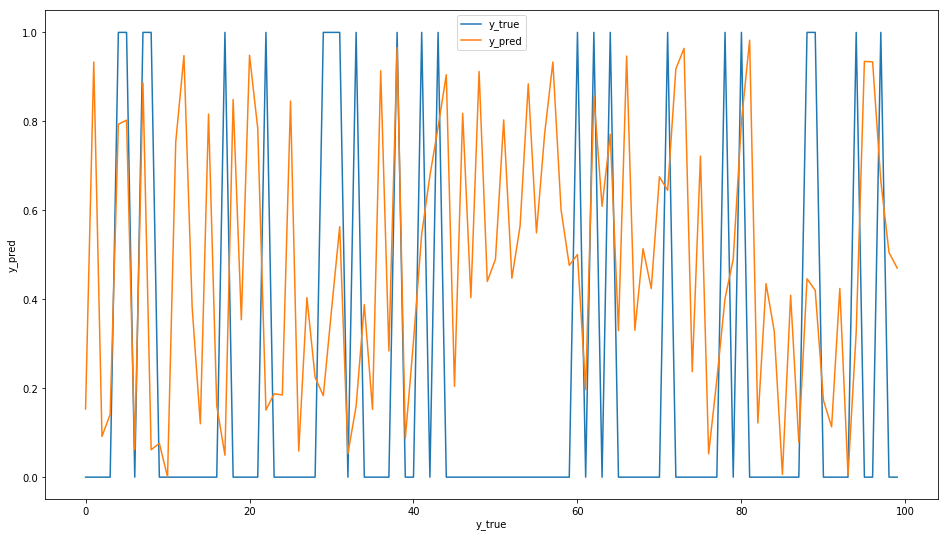

In [49]:
# use numpy to generate some random numbers

# for regression problems
# y_true is a list of binary indicators (0, 1)
y_true = np.where(np.random.randn(100, ) >= 0.5, 1, 0)
# generate y_predict
y_pred = np.random.random(100, )

# plot
plt.figure(figsize=(16, 9))
plt.plot(y_true)
plt.plot(y_pred)
plt.xlabel('y_true')
plt.ylabel('y_pred')
plt.legend(['y_true', 'y_pred'])
plt.show()

### <a name='logloss'></a>Log Loss
Log loss, a form of [cross-entropy](https://en.m.wikipedia.org/wiki/Cross_entropy), measures the performance of a classification model. log loss increases as the predicted probability diverges from the actual label. A perfect model would have log loss of 0.

$$
logloss(y, \hat{y}) = -\frac{1}{N}\sum_{i=1}^{N}[y_iln(\hat(y_i))+(1-y_i)ln(1-\hat{y_i})]
$$

The predicted value 

In [40]:
def logloss(y_true, y_pred):
    return -np.mean(y_true*np.log(y_pred) + (1-y_true)*np.log(1-y_pred))

In [50]:
logloss(y_true, y_pred)

0.945224440111369

### <a name='hinge'></a>Hinge Loss

Hinge loss is usually used in SVM in machine learning tasks. The hinge loss is used for training classifiers. For an intended output $y_i = ± 1$ and a classifier score $\hat{y_i}$, the hinge lose of the prediction $\hat{y_i}$ is defined as:

$$
hinge\_loss(y_i, \hat{y_i}) = max(0, 1-\hat{y_i}y_i)
$$

When $y_i$ and $\hat{y_i}$ have the same sign (predicting the right class) and $|\hat{y_i}|\geqslant 1$, the hinge loss is 0; if they have opposite signs, then hinge loss increases linearly with $\hat{y_i}$; if $|\hat{y_i}|<1$, then the margin is not enough even if the prediction is correct (same sign).

Hinge loss is convex and continuous, but not differentiable at $\hat{y_i}y_i=1$. So it CANNOT be used with gradient descent methods of stochastic gradient descent methods which rely on differentiability over the entire domain. ([ref](https://en.wikipedia.org/wiki/Loss_functions_for_classification#Hinge_loss))

In [52]:
def hinge_loss(y_true, y_pred):
    return np.mean(np.maximum(0, 1. - y_true*y_pred))

In [53]:
hinge_loss(y_true, y_pred)

0.8784042912995109

### <a name='kl'></a>KL Divergence
Kullback-Leibler Divergene, a.k.a. KLD or relative entropy, measures how far apart the predicted distributions are. More formally, KLD measures how one probability distribution diverges from a second expected probability distribution. The smaller the KLD, the closer the distributions. For example, in the below graph, KLD computes the shaded area, where the two distributions do not overlap.

$$
kld(y, \hat{y}) = \sum_{i=1}^{N}y_iln(\frac{y_i}{\hat{y_i}})
$$


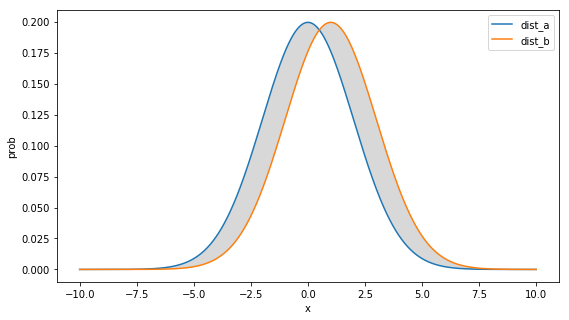

In [61]:
import scipy.stats
x = np.linspace(-10, 10, 10001)
# distribution a with mean=-1, sd=2
dist_a = scipy.stats.norm.pdf(x, 0, 2)
# distribution b with mean=1, sd=2
dist_b = scipy.stats.norm.pdf(x, 1, 2)

plt.figure(figsize=(9,5))
plt.plot(x, dist_a)
plt.plot(x, dist_b)
plt.fill_between(x, dist_a, dist_b, where=dist_b>=dist_a, facecolor='grey', alpha=0.3, interpolate=True)
plt.fill_between(x, dist_a, dist_b, where=dist_b<=dist_a, facecolor='grey', alpha=0.3, interpolate=True)
plt.legend(['dist_a', 'dist_b'])
plt.xlabel('x')
plt.ylabel('prob')
plt.show()

In [62]:
def kld(y_true, y_pred):
    # np.clip(a, a_min, a_max, out=None)
    # use machine epsilon to prevent ln of 0
    y_true = np.clip(y_true, np.finfo(float).eps, 1)
    y_pred = np.clip(y_pred, np.finfo(float).eps, 1)
    return np.sum(y_true * np.log(y_true/y_pred))

In [63]:
kld(y_true, y_pred)

20.103535043374137